## **1. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## **2. Import the necessary libraries**
---

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.3.0
numpy:       1.18.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


## **3.Create a function to plot image without axis**
---

In [3]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

<function implt at 0x7f98338c0b70>


## **4. Set matplotlib to have seaborn plot style**
---

In [4]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **5. Prepare Cifar10 data for training and testing**
---
* Step 1: Load the cifar10 
* Step 2: Check the shape and type of the data
* Step 3: Convert the data into float32 and rescale the values from the range of 0\~255 into 0\~1
* Step 4: Retrieve the row size and the column size of each image
* Step 5: Perform one-hot enconding on the labels
* Step 6: Retrieve the number of classes in this problem

In [5]:
                                                                                # Step 1
data            = cifar10.load_data()
(trDat, trLbl)  = data[0]
(tsDat, tsLbl)  = data[1]

                                                                                # Step 2
print("The shape of trDat is", trDat.shape, "and the type of trDat is", trDat.dtype)
print("The shape of tsDat is", tsDat.shape, "and the type of tsDat is", tsDat.dtype)
print("")
print("The shape of trLbl is", trLbl.shape, "and the type of trLbl is", trLbl.dtype)
print("The shape of tsLbl is", tsLbl.shape, "and the type of tsLbl is", tsLbl.dtype)

                                                                                # Step 3
trDat           = trDat.astype('float32')/255
tsDat           = tsDat.astype('float32')/255

                                                                                # Step 4
imgrows         = trDat.shape[1]
imgclms         = trDat.shape[2]
channel         = trDat.shape[3]

                                                                                # Step 5
trLbl           = to_categorical(trLbl)
tsLbl           = to_categorical(tsLbl)
                               
num_classes     = tsLbl.shape[1]                                                # Step 6

170500096/170498071 [==============================] - 11s 0us/step
The shape of trDat is (50000, 32, 32, 3) and the type of trDat is uint8
The shape of tsDat is (10000, 32, 32, 3) and the type of tsDat is uint8

The shape of trLbl is (50000, 1) and the type of trLbl is uint8
The shape of tsLbl is (10000, 1) and the type of tsLbl is uint8


## **6. Define the resnet model (to be completed)**
___
* Step 1: Setup the optimizer to be used for training
* Step 2: Set a name for the coming model (required for saving)
* Step 3: Function to create layers for the resnet
* Step 4: Function to create residual blocks
* Step 5: Define the resnet model (to be completed)
* Step 6: Create models for training and testing
* Step 7: Display the summary of the model of interest 

In [6]:
optmz       = optimizers.Adam(lr=0.001)                                         # Step 1
modelname   = 'cifar10ResV1Cfg5'                                                # Step 2

                                                                                # Step 3
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):

    convLyr     = Conv2D(numFilters,
                         kernel_size=kernelSz,
                         strides=strides,
                         padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4),
                         name=lyrName+'_conv' if lyrName else None)
    x           = inputs
    
    if convFirst:
        x       = convLyr(x)
        
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
            
        x       = convLyr(x)
    return x

                                                                                # Step 4
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    
    x       = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr  = str(run+1)
        
        if downsampleOnFirst and run == 0:
            strides     = 2
            
        y       = resLyr(inputs=x,
                         numFilters=numFilters,
                         strides=strides,
                         lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y       = resLyr(inputs=y,
                         numFilters=numFilters,
                         activation=None,
                         lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x   = resLyr(inputs=x,
                         numFilters=numFilters,
                         kernelSz=1,
                         strides=strides,
                         activation=None,
                         batchNorm=False,
                         lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x       = add([x,y],
                      name=names+'_Blk'+blkStr+'_add' if names else None)
        x       = Activation('relu',
                             name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
        
    return x
    
                                                                                # Step 5
def createResNetV1(inputShape=(32,32,3), numClasses=10):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, lyrName='Inpt')
    v = resBlkV1(inputs=v, numFilters=16, numBlocks=3, downsampleOnFirst=False, names='Stg1')
    v = resBlkV1(inputs=v, numFilters=32, numBlocks=3, downsampleOnFirst=True,  names='Stg2')
    v = resBlkV1(inputs=v, numFilters=64, numBlocks=3, downsampleOnFirst=True,  names='Stg3')
    v = AveragePooling2D(pool_size=8,  name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numClasses, activation='softmax', kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model

                                                                                # Step 6
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()                                                                 # Step 7

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 32, 32, 16)   64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 32, 32, 16)   0           Inpt_bn[0][0]                    
_______________________________________________________________________________________

## **7. Create the callbacks to be applied during training**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callback objects into a list

In [7]:
                                                                                # Step 1
def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 160:
        lr  *= 0.5e-3        
    elif epoch > 140:
        lr  *= 1e-3       
    elif epoch > 120:
        lr  *= 1e-2     
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

                                                                                # Step 2
folderpath      = '/content/gdrive/My Drive/iss/prmls/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger,LRScheduler]                           # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/iss/prmls/colab/cifar10ResV1Cfg5.hdf5
Path to log:   /content/gdrive/My Drive/iss/prmls/colab/cifar10ResV1Cfg5.csv


## **8. Train the deep learning model with image augmentation (to be completed)**
___
* Step 1: Create the image data generator (for image augmentation)
* Step 2: Train the model with generator

In [8]:
                                                                                # Step 1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                             rotation_range=20, horizontal_flip=True, 
                             vertical_flip=False)
                                                                                # Step 2
model.fit_generator(datagen.flow(trDat, trLbl, batch_size=128), 
                    validation_data=(tsDat, tsLbl), epochs=5, 
                    verbose=1, 
                    steps_per_epoch=len(trDat)/128, callbacks=callbacks_list)


Instructions for updating:
Please use Model.fit, which supports generators.
Learning rate:  0.001
Epoch 1/5
391/390 [==============================] - 43s 111ms/step - loss: 1.6534 - accuracy: 0.4508 - val_loss: 1.9017 - val_accuracy: 0.4452
Learning rate:  0.001
Epoch 2/5
391/390 [==============================] - 43s 110ms/step - loss: 1.3125 - accuracy: 0.5829 - val_loss: 1.6630 - val_accuracy: 0.5443
Learning rate:  0.001
Epoch 3/5
391/390 [==============================] - 43s 109ms/step - loss: 1.1595 - accuracy: 0.6401 - val_loss: 1.2930 - val_accuracy: 0.6073
Learning rate:  0.001
Epoch 4/5
391/390 [==============================] - 42s 107ms/step - loss: 1.0581 - accuracy: 0.6766 - val_loss: 1.4315 - val_accuracy: 0.5817
Learning rate:  0.001
Epoch 5/5
391/390 [==============================] - 42s 108ms/step - loss: 0.9762 - accuracy: 0.7065 - val_loss: 1.5833 - val_accuracy: 0.5750


## **9. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction


In [9]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(tsDat)                                            # Step 2
print("Prediction completes.")

Prediction completes.


## **10. Report classification metrics**
---
* Step 1: Setup the label
* Step 2: Convert label from one-hot to integer
* Step 3: Calculate the accuracy score
* Step 4: Generate classification report

In [10]:
                                                                                # Step 1
labelname   = ['airplane',          # The label for reporting metrics
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 60.73%
              precision    recall  f1-score   support

    airplane     0.7121    0.5490    0.6200      1000
  automobile     0.8179    0.8040    0.8109      1000
        bird     0.7220    0.3090    0.4328      1000
         cat     0.3850    0.5940    0.4672      1000
        deer     0.7755    0.2970    0.4295      1000
         dog     0.7639    0.3170    0.4481      1000
        frog     0.4202    0.9210    0.5771      1000
       horse     0.7578    0.6760    0.7146      1000
        ship     0.5902    0.9000    0.7129      1000
       truck     0.8134    0.7060    0.7559      1000

    accuracy                         0.6073     10000
   macro avg     0.6758    0.6073    0.5969     10000
weighted avg     0.6758    0.6073    0.5969     10000



## **11. Print confusion matrix**
---

In [11]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[549  22  40  32   1   1  38  14 272  31]
 [ 24 804   0   8   0   0  22   1 102  39]
 [ 87  11 309 164  37  22 296  24  38  12]
 [ 13  17  21 594   9  47 232  12  41  14]
 [ 18   6  24 123 297   8 377 118  24   5]
 [  3   9  18 416  13 317 151  38  26   9]
 [  3   4   8  49   0   0 921   2  12   1]
 [ 16   3   7 110  22  19  93 676  22  32]
 [ 26  15   1  18   4   1  16   0 900  19]
 [ 32  92   0  29   0   0  46   7  88 706]]


## **12. Plot curves on validation loss and accuracy**
---

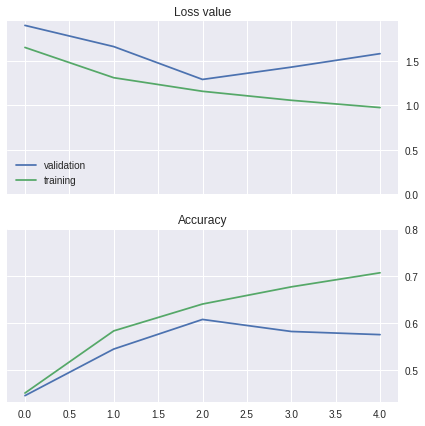

In [12]:
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **13. Save the model plot**
---

In [13]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/iss/prmls/colab/cifar10ResV1Cfg5_plot.png
